# Sign Language MNIST

<br>

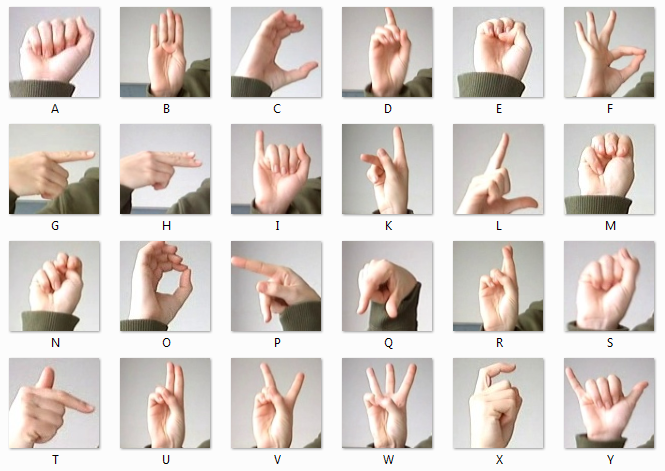

### What changed?
`Dropout reduction` - Dropout percentage was reduced in this version. If you see `(Version 1)` you can clearly infer that the model was underfitting - ***training accuracy < validation accuracy*** the main culprit behind this were the excessive dropout layers. <br>

***`What was happening:`*** During training, a lot of features were dropped due to the more number of dropout layers. Whereas in the validation step dropout didn't exist hence more features were available. This led to better results during validation predictions

In [18]:
# Import packages
import os
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [19]:
os.listdir("/kaggle/input/sign-language-mnist")

['sign_mnist_test.csv',
 'sign_mnist_test',
 'sign_mnist_train',
 'amer_sign2.png',
 'amer_sign3.png',
 'sign_mnist_train.csv',
 'american_sign_language.PNG']

In [20]:
dataset_path = "/kaggle/input/sign-language-mnist"

In [21]:
os.listdir(dataset_path)

['sign_mnist_test.csv',
 'sign_mnist_test',
 'sign_mnist_train',
 'amer_sign2.png',
 'amer_sign3.png',
 'sign_mnist_train.csv',
 'american_sign_language.PNG']

##### As we see the data is not images, rather it is a csv file which contains pixel values

### Explore the dataset and transform the data into images

    1. Check the original dataset (csv file with values for pixels)
    2. Reshape the data for getting the dimensions required by the CNNs

In [22]:
training_csv = os.path.join(dataset_path, "sign_mnist_train.csv")
test_csv = os.path.join(dataset_path, "sign_mnist_test.csv")

train_df = pd.read_csv(training_csv)
test_df = pd.read_csv(test_csv)

print(f"Shape of the dataset: {train_df.shape}")
train_df.head()

Shape of the dataset: (27455, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


#### Split, reshape and visualize the data
    1. Separate the data into x_train, y_train, x_test, y_test
    2. Reshape the 1D pixel array into 3D arrays
    3. Visualize the data by plotting the images

In [23]:
y_train = train_df['label']
y_test = test_df['label']

# Remove the label columns
del train_df['label']
del test_df['label']

x_train = train_df.values
x_test = test_df.values

In [24]:
# Check the shape of the data

print(f"Shape of training images (before reshaping): {x_train.shape}")
print(f"Shape of test images (before reshaping): {x_test.shape}")

Shape of training images (before reshaping): (27455, 784)
Shape of test images (before reshaping): (7172, 784)


In [25]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [26]:
# Reshape the images
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

print(f"Shape of training images (After reshaping): {x_train.shape}")
print(f"Shape of test images (After reshaping): {x_test.shape}")

Shape of training images (After reshaping): (27455, 28, 28, 1)
Shape of test images (After reshaping): (7172, 28, 28, 1)


/tmp/ipykernel_35/1622048423.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


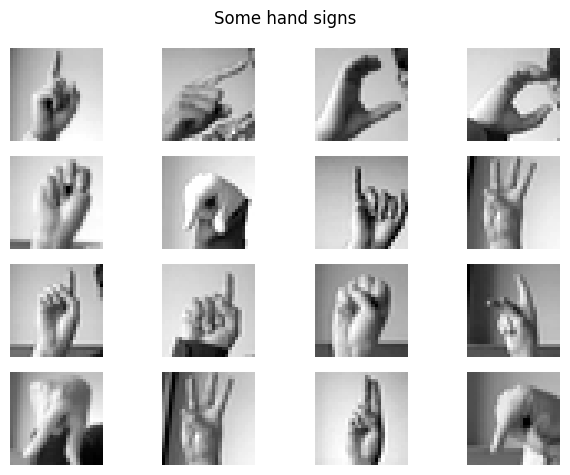

In [27]:
fig, axes = plt.subplots(4,4)
fig.suptitle("Some hand signs")
m = 0

for i in range(4):
    for j in range(4):
        axes[i,j].axis("off")
        axes[i,j].imshow(x_train[m], cmap='gray')
        m+=1
    plt.tight_layout()

### Define augmentation layers and model

    1. Use various augmentation layers available in keras
    2. Visualizing augmentations
    3. Create a model with augmentation and convolution layers

In [28]:
augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal'),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
    tf.keras.layers.RandomContrast(0.2)
])

#### Visualizing augmentations

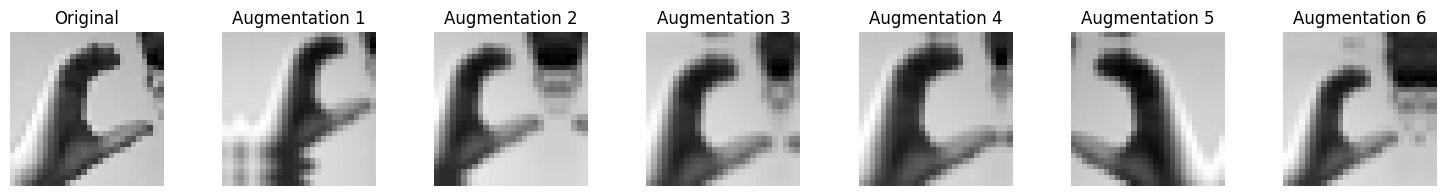

In [29]:
original_image = x_train[2]
num_augmentations = 6
fig, axes = plt.subplots(1, num_augmentations + 1, figsize=(15, 2))

# Display the original image
axes[0].imshow(original_image.squeeze(), cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

# Apply augmentations and display the results
for i in range(num_augmentations):
    # The augmentation layers expect a batch dimension, so add one at index=0
    augmented_image = augmentation_layers(tf.expand_dims(original_image, 0))
    # Remove the batch dimension and squeeze the channel dimension for imshow
    axes[i + 1].imshow(augmented_image[0].numpy().squeeze(), cmap='gray')
    axes[i + 1].set_title(f'Augmentation {i+1}')
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()

In [36]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(28,28,1)),
    augmentation_layers,
    tf.keras.layers.Rescaling(1./255),
    # Conv set 1
    tf.keras.layers.Conv2D(16, (3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2), strides = 2, padding = 'same'),
    # Conv set 2
    tf.keras.layers.Conv2D(32, (3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2), strides = 2, padding = 'same'),
    # Conv set 3
    tf.keras.layers.Conv2D(64, (3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2), strides = 2, padding = 'same'),
    # Conv set 4
    tf.keras.layers.Conv2D(64, (3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2), strides = 2, padding = 'same'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(24, activation='softmax')
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 28, 28, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 4, 4, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 24)                  │          12,312 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,824 (800.09 KB)

 Trainable params: 204,472 (798.72 KB)

 Non-trainable params: 352 (1.38 KB)

### Compile and train the model

<br>The callback `ReduceLRonPlateau` would be used here, this does the following: <br><br>
    
        When the training becomes stagnant with a certain value of learning rate, the learning rate is reduced by a certain factor. You can imagine this like being stuck on a plateau and then jumping down the plateau to go to the bottom of the mountain.

In [31]:
# ReduceLRonPlateau callback
lr_reduction_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            factor=0.5,
                                                            verbose=1,
                                                            patience=2,
                                                            min_lr=0.00001)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
# Train the model
history = model.fit(x_train, y_train, 
                    batch_size=128, 
                    epochs=30,
                    validation_data = (x_test, y_test), 
                    callbacks=[lr_reduction_callback])

Epoch 1/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.2675 - loss: 2.4808 - val_accuracy: 0.0287 - val_loss: 6.2018 - learning_rate: 0.0010
Epoch 2/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7207 - loss: 0.7939 - val_accuracy: 0.2497 - val_loss: 3.8342 - learning_rate: 0.0010
Epoch 3/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8455 - loss: 0.4398 - val_accuracy: 0.8607 - val_loss: 0.3707 - learning_rate: 0.0010
Epoch 4/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8977 - loss: 0.2928 - val_accuracy: 0.9262 - val_loss: 0.1859 - learning_rate: 0.0010
Epoch 5/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9297 - loss: 0.2077 - val_accuracy: 0.8602 - val_loss: 0.4218 - learning_rate: 0.0010
Epoch 6/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9372 - loss: 0.1808 - val_accuracy: 0.9400 - val_loss: 0.1781 - learning_rate: 0.0010
Epoch 7/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9520 - loss: 0.

In [33]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9940 - loss: 0.0134
Accuracy of the model is -  99.51199293136597 %


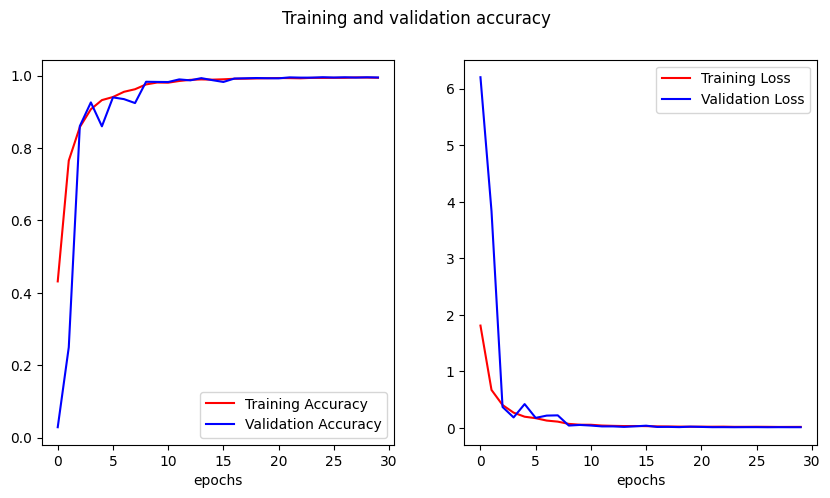

In [35]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()